# **Bioinformatics Project**
# Notebook 1
This project explores data on histone deacetylase inhibitors. This first notebook contains Part 1 and Part 2 where data is collected and pre-processed, and exloratory analysis is performed. The second notebook contains Part 3 and Part 4 where molecular descriptors are calculated and a model is built. 

# **Part 1 Download Bioactivity Data**

In **Part 1**, we will be performing Data Collection and Pre-Processing from the ChEMBL Database. The ChEMBL database contains curated bioactivity data of more than 2 million compounds. 




## **Installing libraries**

Install ChEMBL web service package, enables us to retrieve bioactivity data from the ChEMBL Database.

In [1]:
! pip install chembl_webresource_client

     |████████████████████████████████| 55 kB 1.8 MB/s 
     |████████████████████████████████| 596 kB 25.3 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
  Attempting uninstall: itsdangerous
    Found existing installation: itsdangerous 1.1.0
    Uninstalling itsdangerous-1.1.0:
      Successfully uninstalled itsdangerous-1.1.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
flask 1.1.4 requires itsdangerous<2.0,>=0.24, but you have itsdangerous 2.0.1 which is incompatible.


In [27]:
import pandas as pd
import numpy as np
from chembl_webresource_client.new_client import new_client

## **Search for Target protein**

### **Target search for Histone Deacetylase**

- The target protein is histone deacteylase (HDAC), this protein is generally associated with the inhibition of gene transcription among other regulatory functions
- HDAC inhibitors are a class of anti-cancer agents and two are FDA approved for clinical use in cancer patients

In [3]:
# Target search for HDAC
target = new_client.target
target_query = target.search('histone deacetylase')
targets = pd.DataFrame.from_dict(target_query)
targets

,cross_references,organism,pref_name,score,species_group_flag,target_chembl_id,target_components,target_type,tax_id
0,[],Rattus norvegicus,Histone deacetylase,24.0,False,CHEMBL2095943,"[{'accession': 'Q6P6W3', 'component_descriptio...",PROTEIN FAMILY,10116
1,[],Mus musculus,Histone deacetylase,24.0,False,CHEMBL3832944,"[{'accession': 'Q8VH37', 'component_descriptio...",PROTEIN FAMILY,10090
2,"[{'xref_id': 'Q9Z2V6', 'xref_name': None, 'xre...",Mus musculus,Histone deacetylase 5,23.0,False,CHEMBL2768,"[{'accession': 'Q9Z2V6', 'component_descriptio...",SINGLE PROTEIN,10090
3,"[{'xref_id': 'Q94F81', 'xref_name': None, 'xre...",Zea mays,Histone deacetylase HD2,23.0,False,CHEMBL4919,"[{'accession': 'Q94F81', 'component_descriptio...",SINGLE PROTEIN,4577
4,[],Homo sapiens,Histone deacetylase,23.0,False,CHEMBL2093865,"[{'accession': 'Q13547', 'component_descriptio...",PROTEIN FAMILY,9606
...,...,...,...,...,...,...,...,...,...
211,[],Homo sapiens,Histone-lysine N-methyltransferase 2A/WDR5,5.0,False,CHEMBL3883320,"[{'accession': 'P61964', 'component_descriptio...",PROTEIN-PROTEIN INTERACTION,9606
212,[],Homo sapiens,Bifunctional arginine demethylase and lysyl-hy...,5.0,False,CHEMBL4523345,"[{'accession': 'Q6NYC1', 'component_descriptio...",SINGLE PROTEIN,9606
213,"[{'xref_id': 'Q9NQR1', 'xref_name': None, 'xre...",Homo sapiens,N-lysine methyltransferase SETD8,4.0,False,CHEMBL1795176,"[{'accession': 'Q9NQR1', 'component_descriptio...",SINGLE PROTEIN,9606
214,[],Homo sapiens,PRMT5/MEP50 complex,4.0,False,CHEMBL3137261,"[{'accession': 'O14744', 'component_descriptio...",PROTEIN COMPLEX,9606


### **Select and retrieve bioactivity data for *Human Histone deacetylase (HDAC)* (fifth entry)**

We will assign the fifth entry (which corresponds to the target protein, *Human HDAC*) to the ***selected_target*** variable 

In [4]:
selected_target = targets.target_chembl_id[4]
selected_target

'CHEMBL2093865'

Here, we will retrieve bioactivity data for *Human HDAC* (ChEMBL2093865).

In [5]:
activity = new_client.activity
res = activity.filter(target_chembl_id=selected_target).filter(standard_type="IC50")

In [6]:
df = pd.DataFrame.from_dict(res)

In [7]:
df

,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,assay_variant_accession,assay_variant_mutation,bao_endpoint,bao_format,bao_label,canonical_smiles,data_validity_comment,data_validity_description,document_chembl_id,document_journal,document_year,ligand_efficiency,molecule_chembl_id,molecule_pref_name,parent_molecule_chembl_id,pchembl_value,potential_duplicate,qudt_units,record_id,relation,src_id,standard_flag,standard_relation,standard_text_value,standard_type,standard_units,standard_upper_value,standard_value,target_chembl_id,target_organism,target_pref_name,target_tax_id,text_value,toid,type,units,uo_units,upper_value,value
0,None,35912,[],CHEMBL694903,In vitro inhibitory activity against histone d...,B,None,None,BAO_0000190,BAO_0000224,protein format,NNC(=O)NCCCCCC(=O)Nc1ccccc1,Outside typical range,Values for this activity type are unusually la...,CHEMBL1144863,Bioorg. Med. Chem. Lett.,2003,None,CHEMBL112539,None,CHEMBL112539,None,True,http://www.openphacts.org/units/Nanomolar,262402,=,1,True,=,None,IC50,nM,None,150000.0,CHEMBL2093865,Homo sapiens,Histone deacetylase,9606,None,None,IC50,uM,UO_0000065,None,150.0
1,None,35914,[],CHEMBL694903,In vitro inhibitory activity against histone d...,B,None,None,BAO_0000190,BAO_0000224,protein format,NNC(=O)NCCCCC(=O)Nc1ccccc1,Outside typical range,Values for this activity type are unusually la...,CHEMBL1144863,Bioorg. Med. Chem. Lett.,2003,None,CHEMBL136792,None,CHEMBL136792,None,False,http://www.openphacts.org/units/Nanomolar,262401,>,1,True,>,None,IC50,nM,None,1000000.0,CHEMBL2093865,Homo sapiens,Histone deacetylase,9606,None,None,IC50,uM,UO_0000065,None,1000.0
2,None,37094,[],CHEMBL694903,In vitro inhibitory activity against histone d...,B,None,None,BAO_0000190,BAO_0000224,protein format,O=C(CCCCCCNC(=O)C(F)(F)F)Nc1ccccc1,None,None,CHEMBL1144863,Bioorg. Med. Chem. Lett.,2003,None,CHEMBL137003,None,CHEMBL137003,None,False,http://www.openphacts.org/units/Nanomolar,262412,>,1,True,>,None,IC50,nM,None,100000.0,CHEMBL2093865,Homo sapiens,Histone deacetylase,9606,None,None,IC50,uM,UO_0000065,None,100.0
3,None,41900,[],CHEMBL694903,In vitro inhibitory activity against histone d...,B,None,None,BAO_0000190,BAO_0000224,protein format,O=C(CCCCCCC(=O)Nc1ccccc1)NO,None,None,CHEMBL1144863,Bioorg. Med. Chem. Lett.,2003,"{'bei': '24.79', 'le': '0.47', 'lle': '4.08', ...",CHEMBL98,VORINOSTAT,CHEMBL98,6.55,True,http://www.openphacts.org/units/Nanomolar,262392,=,1,True,=,None,IC50,nM,None,280.0,CHEMBL2093865,Homo sapiens,Histone deacetylase,9606,None,None,IC50,uM,UO_0000065,None,0.28
4,None,43087,[],CHEMBL694903,In vitro inhibitory activity against histone d...,B,None,None,BAO_0000190,BAO_0000224,protein format,C#CCN(CC#C)CCCCCCC(=O)Nc1ccccc1,None,None,CHEMBL1144863,Bioorg. Med. Chem. Lett.,2003,None,CHEMBL264784,None,CHEMBL264784,None,False,http://www.openphacts.org/units/Nanomolar,262407,>,1,True,>,None,IC50,nM,None,100000.0,CHEMBL2093865,Homo sapiens,Histone deacetylase,9606,None,None,IC50,uM,UO_0000065,None,100.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3066,None,20669071,[],CHEMBL4620316,Inhibition of HDAC in human HeLa cell extracts...,B,None,None,BAO_0000190,BAO_0000219,cell-based format,CN(C)S(=O)(=O)c1ccc(NCCCCCCC(=O)NO)c2nonc12,None,None,CHEMBL4619724,Bioorg Med Chem Lett,2020,"{'bei': '18.06', 'le': '0.37', 'lle': '5.62', ...",CHEMBL4647479,None,CHEMBL4647479,6.96,False,http://www.openphacts.org/units/Nanomolar,3480424,=,1,True,=,None,IC50,nM,None,109.0,CHEMBL2093865,Homo sapiens,Histone deacetylase,9606,None,None,IC50,nM,UO_0000065,None,109.0
3067,None,20669072,[],CHEMBL4620316,Inhibition of HDAC in human HeLa cell extracts...,B,None,None,BAO_0000190,BAO_0000219,cell-based format,CN(C)S(=O)(=O)c1ccc(NCCCCCNC(=O)NCC(=O)NO)c2no...,None,None,CHEMBL4619724,Bioorg Med Chem Lett,2020,"{'bei': '11.55', 'le': '

Finally we will save the resulting bioactivity data to a CSV file **bioactivity_data.csv**.

In [8]:
df.to_csv('HDAC_01_bioactivity_data_raw.csv', index=False)

## **Handling missing data**
Drop any compounds with missing values for the **standard_value** and **canonical_smiles** columns.

In [9]:
print("Number of compounds before removing compounds with missing values:", len(df))
df2 = df[df.standard_value.notna()]
df2 = df2[df.canonical_smiles.notna()]
print("Number of compounds after removing compounds with missing values:", len(df2))

Number of compounds before removing compounds with missing values: 3071
Number of compounds after removing compounds with missing values: 2946


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


In [10]:
df2.head()

,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,assay_variant_accession,assay_variant_mutation,bao_endpoint,bao_format,bao_label,canonical_smiles,data_validity_comment,data_validity_description,document_chembl_id,document_journal,document_year,ligand_efficiency,molecule_chembl_id,molecule_pref_name,parent_molecule_chembl_id,pchembl_value,potential_duplicate,qudt_units,record_id,relation,src_id,standard_flag,standard_relation,standard_text_value,standard_type,standard_units,standard_upper_value,standard_value,target_chembl_id,target_organism,target_pref_name,target_tax_id,text_value,toid,type,units,uo_units,upper_value,value
0,None,35912,[],CHEMBL694903,In vitro inhibitory activity against histone d...,B,None,None,BAO_0000190,BAO_0000224,protein format,NNC(=O)NCCCCCC(=O)Nc1ccccc1,Outside typical range,Values for this activity type are unusually la...,CHEMBL1144863,Bioorg. Med. Chem. Lett.,2003,None,CHEMBL112539,None,CHEMBL112539,None,True,http://www.openphacts.org/units/Nanomolar,262402,=,1,True,=,None,IC50,nM,None,150000.0,CHEMBL2093865,Homo sapiens,Histone deacetylase,9606,None,None,IC50,uM,UO_0000065,None,150.0
1,None,35914,[],CHEMBL694903,In vitro inhibitory activity against histone d...,B,None,None,BAO_0000190,BAO_0000224,protein format,NNC(=O)NCCCCC(=O)Nc1ccccc1,Outside typical range,Values for this activity type are unusually la...,CHEMBL1144863,Bioorg. Med. Chem. Lett.,2003,None,CHEMBL136792,None,CHEMBL136792,None,False,http://www.openphacts.org/units/Nanomolar,262401,>,1,True,>,None,IC50,nM,None,1000000.0,CHEMBL2093865,Homo sapiens,Histone deacetylase,9606,None,None,IC50,uM,UO_0000065,None,1000.0
2,None,37094,[],CHEMBL694903,In vitro inhibitory activity against histone d...,B,None,None,BAO_0000190,BAO_0000224,protein format,O=C(CCCCCCNC(=O)C(F)(F)F)Nc1ccccc1,None,None,CHEMBL1144863,Bioorg. Med. Chem. Lett.,2003,None,CHEMBL137003,None,CHEMBL137003,None,False,http://www.openphacts.org/units/Nanomolar,262412,>,1,True,>,None,IC50,nM,None,100000.0,CHEMBL2093865,Homo sapiens,Histone deacetylase,9606,None,None,IC50,uM,UO_0000065,None,100.0
3,None,41900,[],CHEMBL694903,In vitro inhibitory activity against histone d...,B,None,None,BAO_0000190,BAO_0000224,protein format,O=C(CCCCCCC(=O)Nc1ccccc1)NO,None,None,CHEMBL1144863,Bioorg. Med. Chem. Lett.,2003,"{'bei': '24.79', 'le': '0.47', 'lle': '4.08', ...",CHEMBL98,VORINOSTAT,CHEMBL98,6.55,True,http://www.openphacts.org/units/Nanomolar,262392,=,1,True,=,None,IC50,nM,None,280.0,CHEMBL2093865,Homo sapiens,Histone deacetylase,9606,None,None,IC50,uM,UO_0000065,None,0.28
4,None,43087,[],CHEMBL694903,In vitro inhibitory activity against histone d...,B,None,None,BAO_0000190,BAO_0000224,protein format,C#CCN(CC#C)CCCCCCC(=O)Nc1ccccc1,None,None,CHEMBL1144863,Bioorg. Med. Chem. Lett.,2003,None,CHEMBL264784,None,CHEMBL264784,None,False,http://www.openphacts.org/units/Nanomolar,262407,>,1,True,>,None,IC50,nM,None,100000.0,CHEMBL2093865,Homo sapiens,Histone deacetylase,9606,None,None,IC50,uM,UO_0000065,None,100.0


Drop duplicates of compounds with the same structure. 

In [11]:
print("Number of compounds before removing compounds with duplicate structures:", len(df2))
df2_nr = df2.drop_duplicates(['canonical_smiles'])
df2_nr
print("Number of compounds after removing compounds with duplicate structures:", len(df2_nr))

Number of compounds before removing compounds with duplicate structures: 2946
Number of compounds after removing compounds with duplicate structures: 2362


## **Data pre-processing of the bioactivity data**

- We will classify compounds into three categories: active, inactive or intermediate.
- The bioactivity data of compounds is in the IC50 unit. 
- Active compound: IC50 < 1000 nM
- Inactive compounds: IC50 > 10,000 nM
- Intermediate compounds: IC50 between 1000 and 10,000 nM

### **Combine the 3 columns (molecule_chembl_id, canonical_smiles, standard_value) and bioactivity_class into a DataFrame**

In [12]:
selection = ['molecule_chembl_id','canonical_smiles','standard_value']
df3 = df2_nr[selection]
df3

,molecule_chembl_id,canonical_smiles,standard_value
0,CHEMBL112539,NNC(=O)NCCCCCC(=O)Nc1ccccc1,150000.0
1,CHEMBL136792,NNC(=O)NCCCCC(=O)Nc1ccccc1,1000000.0
2,CHEMBL137003,O=C(CCCCCCNC(=O)C(F)(F)F)Nc1ccccc1,100000.0
3,CHEMBL98,O=C(CCCCCCC(=O)Nc1ccccc1)NO,280.0
4,CHEMBL264784,C#CCN(CC#C)CCCCCCC(=O)Nc1ccccc1,100000.0
...,...,...,...
3065,CHEMBL4637992,CN(C)S(=O)(=O)c1ccc(NCCCCCC(=O)NO)c2nonc12,205.0
3066,CHEMBL4647479,CN(C)S(=O)(=O)c1ccc(NCCCCCCC(=O)NO)c2nonc12,109.0
3067,CHEMBL4644623,CN(C)S(=O)(=O)c1ccc(NCCCCCNC(=O)NCC(=O)NO)c2no...,7580.0
3068,CHEMBL4636091,CC(C)CC(NC(=O)NCCCCCNc1ccc(S(=O)(=O)N(C)C)c2no...,100000.0


Saves dataframe to CSV file

In [13]:
df3.to_csv('HDAC_02_bioactivity_data_preprocessed.csv', index=False)

### **Labeling compounds as either being active, inactive or intermediate**

In [14]:
df4 = pd.read_csv('HDAC_02_bioactivity_data_preprocessed.csv')

In [15]:
bioactivity_threshold = []
for i in df4.standard_value:
  if float(i) >= 10000:
    bioactivity_threshold.append("inactive")
  elif float(i) <= 1000:
    bioactivity_threshold.append("active")
  else:
    bioactivity_threshold.append("intermediate")

In [16]:
bioactivity_class = pd.Series(bioactivity_threshold, name='bioactivity_class')
df5 = pd.concat([df4, bioactivity_class], axis=1)
df5

,molecule_chembl_id,canonical_smiles,standard_value,bioactivity_class
0,CHEMBL112539,NNC(=O)NCCCCCC(=O)Nc1ccccc1,150000.0,inactive
1,CHEMBL136792,NNC(=O)NCCCCC(=O)Nc1ccccc1,1000000.0,inactive
2,CHEMBL137003,O=C(CCCCCCNC(=O)C(F)(F)F)Nc1ccccc1,100000.0,inactive
3,CHEMBL98,O=C(CCCCCCC(=O)Nc1ccccc1)NO,280.0,active
4,CHEMBL264784,C#CCN(CC#C)CCCCCCC(=O)Nc1ccccc1,100000.0,inactive
...,...,...,...,...
2357,CHEMBL4637992,CN(C)S(=O)(=O)c1ccc(NCCCCCC(=O)NO)c2nonc12,205.0,active
2358,CHEMBL4647479,CN(C)S(=O)(=O)c1ccc(NCCCCCCC(=O)NO)c2nonc12,109.0,active
2359,CHEMBL4644623,CN(C)S(=O)(=O)c1ccc(NCCCCCNC(=O)NCC(=O)NO)c2no...,7580.0,intermediate
2360,CHEMBL4636091,CC(C)CC(NC(=O)NCCCCCNc1ccc(S(=O)(=O)N(C)C)c2no...,100000.0,inactive


In [17]:
df5.bioactivity_class.unique()

array(['inactive', 'active', 'intermediate'], dtype=object)

Save dataframe to CSV file

In [18]:
df5.to_csv('HDAC_03_bioactivity_data_curated.csv', index=False)

# **Part 2 Exploratory Data Analysis**

In **Part 2**, we will be performing Descriptor Calculation and Exploratory Data Analysis.

---

## **Install conda and rdkit**
- rdkit allows you to compute the molecular descriptors for the compounds in the dataset from part 1 
- The dataset from part 1 contains the name of compounds, the corresponding smiles notation (which is the information about the chemical structure) which we will use in part 2 in order to compute the molecular descriptors, it also contains the IC50 value and the bioactivity class (active, inactive and intermediate) 
- Here we select only the active and inactive so we can compare between the two bioactivity classes of the compounds and perform statistical analysis

In [19]:
! wget https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.2-Linux-x86_64.sh
! chmod +x Miniconda3-py37_4.8.2-Linux-x86_64.sh
! bash ./Miniconda3-py37_4.8.2-Linux-x86_64.sh -b -f -p /usr/local
! conda install -c rdkit rdkit -y
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')

--2022-02-10 21:17:58--  https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.2-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.130.3, 104.16.131.3, 2606:4700::6810:8203, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.130.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 85055499 (81M) [application/x-sh]
Saving to: ‘Miniconda3-py37_4.8.2-Linux-x86_64.sh’

Miniconda3-py37_4.8 100%[===================>]  81.12M   172MB/s    in 0.5s    

2022-02-10 21:17:59 (172 MB/s) - ‘Miniconda3-py37_4.8.2-Linux-x86_64.sh’ saved [85055499/85055499]

PREFIX=/usr/local
Unpacking payload ...
Solving environment: - \ done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - _libgcc_mutex==0.1=main
    - asn1crypto==1.3.0=py37_0
    - ca-certificates==2020.1.1=0
    - certifi==2019.11.28=py37_0
    - cffi==1.14.0=py37h2e261b9_0
    - chardet==3.0.4=py37_1003
    - conda-package-handling==1.6.0=py37h

## **Load bioactivity data**

In [20]:
df = pd.read_csv('HDAC_03_bioactivity_data_curated.csv')
df

,molecule_chembl_id,canonical_smiles,standard_value,bioactivity_class
0,CHEMBL112539,NNC(=O)NCCCCCC(=O)Nc1ccccc1,150000.0,inactive
1,CHEMBL136792,NNC(=O)NCCCCC(=O)Nc1ccccc1,1000000.0,inactive
2,CHEMBL137003,O=C(CCCCCCNC(=O)C(F)(F)F)Nc1ccccc1,100000.0,inactive
3,CHEMBL98,O=C(CCCCCCC(=O)Nc1ccccc1)NO,280.0,active
4,CHEMBL264784,C#CCN(CC#C)CCCCCCC(=O)Nc1ccccc1,100000.0,inactive
...,...,...,...,...
2357,CHEMBL4637992,CN(C)S(=O)(=O)c1ccc(NCCCCCC(=O)NO)c2nonc12,205.0,active
2358,CHEMBL4647479,CN(C)S(=O)(=O)c1ccc(NCCCCCCC(=O)NO)c2nonc12,109.0,active
2359,CHEMBL4644623,CN(C)S(=O)(=O)c1ccc(NCCCCCNC(=O)NCC(=O)NO)c2no...,7580.0,intermediate
2360,CHEMBL4636091,CC(C)CC(NC(=O)NCCCCCNc1ccc(S(=O)(=O)N(C)C)c2no...,100000.0,inactive


Clean up smiles notation

In [21]:
df_no_smiles = df.drop(columns='canonical_smiles')

In [22]:
smiles = []

for i in df.canonical_smiles.tolist():
  cpd = str(i).split('.')
  cpd_longest = max(cpd, key = len)
  smiles.append(cpd_longest)

smiles = pd.Series(smiles, name = 'canonical_smiles')

In [23]:
df_clean_smiles = pd.concat([df_no_smiles,smiles], axis=1)
df_clean_smiles

,molecule_chembl_id,standard_value,bioactivity_class,canonical_smiles
0,CHEMBL112539,150000.0,inactive,NNC(=O)NCCCCCC(=O)Nc1ccccc1
1,CHEMBL136792,1000000.0,inactive,NNC(=O)NCCCCC(=O)Nc1ccccc1
2,CHEMBL137003,100000.0,inactive,O=C(CCCCCCNC(=O)C(F)(F)F)Nc1ccccc1
3,CHEMBL98,280.0,active,O=C(CCCCCCC(=O)Nc1ccccc1)NO
4,CHEMBL264784,100000.0,inactive,C#CCN(CC#C)CCCCCCC(=O)Nc1ccccc1
...,...,...,...,...
2357,CHEMBL4637992,205.0,active,CN(C)S(=O)(=O)c1ccc(NCCCCCC(=O)NO)c2nonc12
2358,CHEMBL4647479,109.0,active,CN(C)S(=O)(=O)c1ccc(NCCCCCCC(=O)NO)c2nonc12
2359,CHEMBL4644623,7580.0,intermediate,CN(C)S(=O)(=O)c1ccc(NCCCCCNC(=O)NCC(=O)NO)c2no...
2360,CHEMBL4636091,100000.0,inactive,CC(C)CC(NC(=O)NCCCCCNc1ccc(S(=O)(=O)N(C)C)c2no...


## **Calculate Lipinski descriptors**
Lipinski's rule of five evaluates the druglikeness of compounds through describing the pharmacokinetic properties of compounds, namely Absorption, Distribution, Metabolism and Excretion (ADME). This tells us whether the compound can be absorbed in the body, distributed to the proper organs and tissues, become metabolised and be excreted from the body.

### The Lipinski's Rule stated the following:
* Molecular weight < 500 Dalton
* Octanol-water partition coefficient (LogP) < 5
* Hydrogen bond donors < 5
* Hydrogen bond acceptors < 10 

All of the values are multiples of five

### **Import libraries**

In [24]:
from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski

### **Calculate descriptors**

In [29]:
# Inspired by: https://codeocean.com/explore/capsules?query=tag:data-curation
# modified to include the descriptors for this analysis 

def lipinski(smiles, verbose=False):

    moldata= []
    for elem in smiles:
        mol=Chem.MolFromSmiles(elem) 
        moldata.append(mol)
       
    baseData= np.arange(1,1)
    i=0  
    for mol in moldata:        
       
        desc_MolWt = Descriptors.MolWt(mol)
        desc_MolLogP = Descriptors.MolLogP(mol)
        desc_NumHDonors = Lipinski.NumHDonors(mol)
        desc_NumHAcceptors = Lipinski.NumHAcceptors(mol)
           
        row = np.array([desc_MolWt,
                        desc_MolLogP,
                        desc_NumHDonors,
                        desc_NumHAcceptors])   
    
        if(i==0):
            baseData=row
        else:
            baseData=np.vstack([baseData, row])
        i=i+1      
    
    columnNames=["MW","LogP","NumHDonors","NumHAcceptors"]   
    descriptors = pd.DataFrame(data=baseData,columns=columnNames)
    
    return descriptors

In [30]:
df_lipinski = lipinski(df_clean_smiles.canonical_smiles)
df_lipinski

,MW,LogP,NumHDonors,NumHAcceptors
0,264.329,1.3584,4.0,3.0
1,250.302,0.9683,4.0,3.0
2,316.323,3.2541,2.0,2.0
3,264.325,2.4711,3.0,3.0
4,296.414,3.1440,1.0,2.0
...,...,...,...,...
2357,371.419,0.9508,3.0,8.0
2358,385.446,1.3409,3.0,8.0
2359,443.486,-0.1401,5.0,9.0
2360,499.594,1.2746,5.0,9.0


### **Combine DataFrames**

First we view the two dataframes individually

In [31]:
df_lipinski

,MW,LogP,NumHDonors,NumHAcceptors
0,264.329,1.3584,4.0,3.0
1,250.302,0.9683,4.0,3.0
2,316.323,3.2541,2.0,2.0
3,264.325,2.4711,3.0,3.0
4,296.414,3.1440,1.0,2.0
...,...,...,...,...
2357,371.419,0.9508,3.0,8.0
2358,385.446,1.3409,3.0,8.0
2359,443.486,-0.1401,5.0,9.0
2360,499.594,1.2746,5.0,9.0


In [32]:
df_clean_smiles

,molecule_chembl_id,standard_value,bioactivity_class,canonical_smiles
0,CHEMBL112539,150000.0,inactive,NNC(=O)NCCCCCC(=O)Nc1ccccc1
1,CHEMBL136792,1000000.0,inactive,NNC(=O)NCCCCC(=O)Nc1ccccc1
2,CHEMBL137003,100000.0,inactive,O=C(CCCCCCNC(=O)C(F)(F)F)Nc1ccccc1
3,CHEMBL98,280.0,active,O=C(CCCCCCC(=O)Nc1ccccc1)NO
4,CHEMBL264784,100000.0,inactive,C#CCN(CC#C)CCCCCCC(=O)Nc1ccccc1
...,...,...,...,...
2357,CHEMBL4637992,205.0,active,CN(C)S(=O)(=O)c1ccc(NCCCCCC(=O)NO)c2nonc12
2358,CHEMBL4647479,109.0,active,CN(C)S(=O)(=O)c1ccc(NCCCCCCC(=O)NO)c2nonc12
2359,CHEMBL4644623,7580.0,intermediate,CN(C)S(=O)(=O)c1ccc(NCCCCCNC(=O)NCC(=O)NO)c2no...
2360,CHEMBL4636091,100000.0,inactive,CC(C)CC(NC(=O)NCCCCCNc1ccc(S(=O)(=O)N(C)C)c2no...


We combine the two dataframes

In [33]:
df_combined = pd.concat([df_clean_smiles,df_lipinski], axis=1)

In [34]:
df_combined

,molecule_chembl_id,standard_value,bioactivity_class,canonical_smiles,MW,LogP,NumHDonors,NumHAcceptors
0,CHEMBL112539,150000.0,inactive,NNC(=O)NCCCCCC(=O)Nc1ccccc1,264.329,1.3584,4.0,3.0
1,CHEMBL136792,1000000.0,inactive,NNC(=O)NCCCCC(=O)Nc1ccccc1,250.302,0.9683,4.0,3.0
2,CHEMBL137003,100000.0,inactive,O=C(CCCCCCNC(=O)C(F)(F)F)Nc1ccccc1,316.323,3.2541,2.0,2.0
3,CHEMBL98,280.0,active,O=C(CCCCCCC(=O)Nc1ccccc1)NO,264.325,2.4711,3.0,3.0
4,CHEMBL264784,100000.0,inactive,C#CCN(CC#C)CCCCCCC(=O)Nc1ccccc1,296.414,3.1440,1.0,2.0
...,...,...,...,...,...,...,...,...
2357,CHEMBL4637992,205.0,active,CN(C)S(=O)(=O)c1ccc(NCCCCCC(=O)NO)c2nonc12,371.419,0.9508,3.0,8.0
2358,CHEMBL4647479,109.0,active,CN(C)S(=O)(=O)c1ccc(NCCCCCCC(=O)NO)c2nonc12,385.446,1.3409,3.0,8.0
2359,CHEMBL4644623,7580.0,intermediate,CN(C)S(=O)(=O)c1ccc(NCCCCCNC(=O)NCC(=O)NO)c2no...,443.486,-0.1401,5.0,9.0
2360,CHEMBL4636091,100000.0,inactive,CC(C)CC(NC(=O)NCCCCCNc1ccc(S(=O)(=O)N(C)C)c2no...,499.594,1.2746,5.0,9.0


### **Convert IC50 to pIC50**
To allow **IC50** data to be more uniformly distributed, we will convert **IC50** to the negative logarithmic scale which is essentially **-log10(IC50)**.
- **IC50** value has uneven distribution of data points so we transform it 

This custom function pIC50() will accept a DataFrame as input and will:
* Take the IC50 values from the ``standard_value`` column and converts it from nM to M by multiplying the value by 10$^{-9}$
* Take the molar value and apply -log10
* Delete the ``standard_value`` column and create a new ``pIC50`` column

- Note: the IC50 value has large numbers and after performing negative logarithm some of the very large values will become a negative value, in order to prevent this we need to cap the value to 100 million
- We prevent the resulting pIC50 from being negative as this would make interpretation more difficult 

In [35]:
# https://github.com/chaninlab/estrogen-receptor-alpha-qsar/blob/master/02_ER_alpha_RO5.ipynb

def pIC50(input):
    pIC50 = []

    for i in input['standard_value_norm']:
        molar = i*(10**-9) # convert nM to M
        pIC50.append(-np.log10(molar))

    input['pIC50'] = pIC50
    x = input.drop('standard_value_norm', 1)
        
    return x

Values greater than 100,000,000 will be fixed at 100,000,000 otherwise the negative logarithmic value will become negative.

In [36]:
def norm_value(input):
    norm = []

    for i in input['standard_value']:
        if i > 100000000:
          i = 100000000 # cap at 100 mil
        norm.append(i)

    input['standard_value_norm'] = norm
    x = input.drop('standard_value', 1)
        
    return x

We will first apply the norm_value() function so that the values in the standard_value column is normalized.

In [37]:
df_norm = norm_value(df_combined)
df_norm

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  # Remove the CWD from sys.path while we load stuff.


,molecule_chembl_id,bioactivity_class,canonical_smiles,MW,LogP,NumHDonors,NumHAcceptors,standard_value_norm
0,CHEMBL112539,inactive,NNC(=O)NCCCCCC(=O)Nc1ccccc1,264.329,1.3584,4.0,3.0,150000.0
1,CHEMBL136792,inactive,NNC(=O)NCCCCC(=O)Nc1ccccc1,250.302,0.9683,4.0,3.0,1000000.0
2,CHEMBL137003,inactive,O=C(CCCCCCNC(=O)C(F)(F)F)Nc1ccccc1,316.323,3.2541,2.0,2.0,100000.0
3,CHEMBL98,active,O=C(CCCCCCC(=O)Nc1ccccc1)NO,264.325,2.4711,3.0,3.0,280.0
4,CHEMBL264784,inactive,C#CCN(CC#C)CCCCCCC(=O)Nc1ccccc1,296.414,3.1440,1.0,2.0,100000.0
...,...,...,...,...,...,...,...,...
2357,CHEMBL4637992,active,CN(C)S(=O)(=O)c1ccc(NCCCCCC(=O)NO)c2nonc12,371.419,0.9508,3.0,8.0,205.0
2358,CHEMBL4647479,active,CN(C)S(=O)(=O)c1ccc(NCCCCCCC(=O)NO)c2nonc12,385.446,1.3409,3.0,8.0,109.0
2359,CHEMBL4644623,intermediate,CN(C)S(=O)(=O)c1ccc(NCCCCCNC(=O)NCC(=O)NO)c2no...,443.486,-0.1401,5.0,9.0,7580.0
2360,CHEMBL4636091,inactive,CC(C)CC(NC(=O)NCCCCCNc1ccc(S(=O)(=O)N(C)C)c2no...,499.594,1.2746,5.0,9.0,100000.0


In [38]:
df_norm.standard_value_norm.describe()

count    2.362000e+03
mean     4.491671e+04
std      3.410063e+05
min      5.000000e-03
25%      8.300000e+01
50%      3.638000e+02
75%      5.000000e+03
max      7.500000e+06
Name: standard_value_norm, dtype: float64

In [39]:
# apply pIC50 function to the normalised dataframe
# deletes IC50 (standard value) column 
df_final = pIC50(df_norm)
df_final

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  # This is added back by InteractiveShellApp.init_path()


,molecule_chembl_id,bioactivity_class,canonical_smiles,MW,LogP,NumHDonors,NumHAcceptors,pIC50
0,CHEMBL112539,inactive,NNC(=O)NCCCCCC(=O)Nc1ccccc1,264.329,1.3584,4.0,3.0,3.823909
1,CHEMBL136792,inactive,NNC(=O)NCCCCC(=O)Nc1ccccc1,250.302,0.9683,4.0,3.0,3.000000
2,CHEMBL137003,inactive,O=C(CCCCCCNC(=O)C(F)(F)F)Nc1ccccc1,316.323,3.2541,2.0,2.0,4.000000
3,CHEMBL98,active,O=C(CCCCCCC(=O)Nc1ccccc1)NO,264.325,2.4711,3.0,3.0,6.552842
4,CHEMBL264784,inactive,C#CCN(CC#C)CCCCCCC(=O)Nc1ccccc1,296.414,3.1440,1.0,2.0,4.000000
...,...,...,...,...,...,...,...,...
2357,CHEMBL4637992,active,CN(C)S(=O)(=O)c1ccc(NCCCCCC(=O)NO)c2nonc12,371.419,0.9508,3.0,8.0,6.688246
2358,CHEMBL4647479,active,CN(C)S(=O)(=O)c1ccc(NCCCCCCC(=O)NO)c2nonc12,385.446,1.3409,3.0,8.0,6.962574
2359,CHEMBL4644623,intermediate,CN(C)S(=O)(=O)c1ccc(NCCCCCNC(=O)NCC(=O)NO)c2no...,443.486,-0.1401,5.0,9.0,5.120331
2360,CHEMBL4636091,inactive,CC(C)CC(NC(=O)NCCCCCNc1ccc(S(=O)(=O)N(C)C)c2no...,499.594,1.2746,5.0,9.0,4.000000


In [40]:
df_final.pIC50.describe()

count    2362.000000
mean        6.246729
std         1.337248
min         2.124939
25%         5.301030
50%         6.439137
75%         7.080922
max        11.301030
Name: pIC50, dtype: float64

Write to CSV file.

In [41]:
df_final.to_csv('HDAC_04_bioactivity_data_3class_pIC50.csv')

### **Removing the 'intermediate' bioactivity class**
Here, we will be removing the ``intermediate`` class from our data set.

In [42]:
df_2class = df_final[df_final['bioactivity_class'] != 'intermediate']
df_2class

,molecule_chembl_id,bioactivity_class,canonical_smiles,MW,LogP,NumHDonors,NumHAcceptors,pIC50
0,CHEMBL112539,inactive,NNC(=O)NCCCCCC(=O)Nc1ccccc1,264.329,1.3584,4.0,3.0,3.823909
1,CHEMBL136792,inactive,NNC(=O)NCCCCC(=O)Nc1ccccc1,250.302,0.9683,4.0,3.0,3.000000
2,CHEMBL137003,inactive,O=C(CCCCCCNC(=O)C(F)(F)F)Nc1ccccc1,316.323,3.2541,2.0,2.0,4.000000
3,CHEMBL98,active,O=C(CCCCCCC(=O)Nc1ccccc1)NO,264.325,2.4711,3.0,3.0,6.552842
4,CHEMBL264784,inactive,C#CCN(CC#C)CCCCCCC(=O)Nc1ccccc1,296.414,3.1440,1.0,2.0,4.000000
...,...,...,...,...,...,...,...,...
2356,CHEMBL4644409,active,C[C@H]1COc2c(N3CCN(C)CC3)c(F)cc3c(=O)c(C(=O)NC...,598.680,2.2133,3.0,11.0,7.677781
2357,CHEMBL4637992,active,CN(C)S(=O)(=O)c1ccc(NCCCCCC(=O)NO)c2nonc12,371.419,0.9508,3.0,8.0,6.688246
2358,CHEMBL4647479,active,CN(C)S(=O)(=O)c1ccc(NCCCCCCC(=O)NO)c2nonc12,385.446,1.3409,3.0,8.0,6.962574
2360,CHEMBL4636091,inactive,CC(C)CC(NC(=O)NCCCCCNc1ccc(S(=O)(=O)N(C)C)c2no...,499.594,1.2746,5.0,9.0,4.000000


Write this to CSV file.

In [43]:
df_2class.to_csv('HDAC_05_bioactivity_data_2class_pIC50.csv')

## **Exploratory Data Analysis (Chemical Space Analysis) via Lipinski descriptors**



### **Import library**

In [44]:
import seaborn as sns
sns.set(style='ticks')
import matplotlib.pyplot as plt

### **Histogram of pIC50 values**

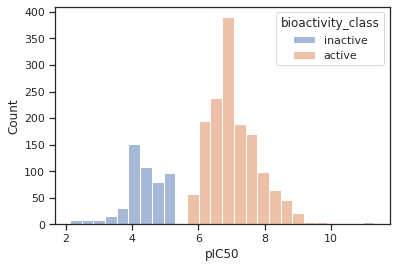

In [45]:
sns.histplot(data=df_2class, x = 'pIC50', hue = 'bioactivity_class')

### **Frequency plot of the 2 bioactivity classes**

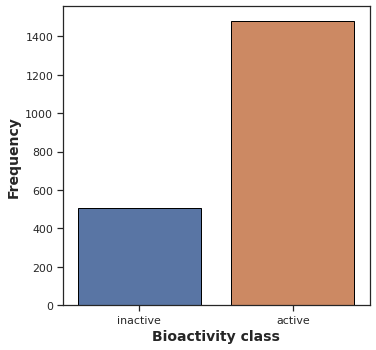

In [46]:
plt.figure(figsize=(5.5, 5.5))

sns.countplot(x='bioactivity_class', data=df_2class, edgecolor='black')

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('Frequency', fontsize=14, fontweight='bold')

plt.savefig('plot_bioactivity_class.pdf')

### **Scatter plot of MW versus LogP (solubility)**

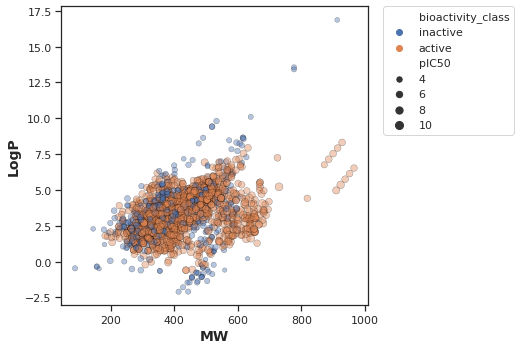

In [47]:
# define fig size
plt.figure(figsize=(5.5, 5.5))

sns.scatterplot(x='MW', y='LogP', data=df_2class, hue='bioactivity_class', size='pIC50', edgecolor='black', alpha=0.4)

plt.xlabel('MW', fontsize=14, fontweight='bold')
plt.ylabel('LogP', fontsize=14, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
plt.savefig('plot_MW_vs_LogP.pdf')

The scatter plot of MW v LogP shows that the 2 bioactivity classes are spanning similar chemical spaces.

### **Box plots**

#### **pIC50 value**

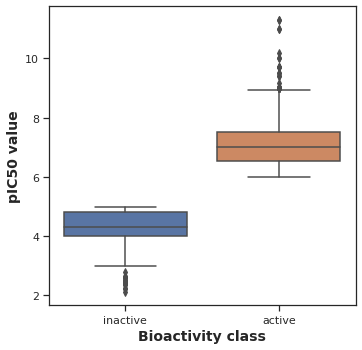

In [49]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'bioactivity_class', y = 'pIC50', data = df_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('pIC50 value', fontsize=14, fontweight='bold')

plt.savefig('plot_ic50.pdf')

**Statistical analysis | Mann-Whitney U Test**

In [50]:
def mannwhitney(descriptor, verbose=False):
  # https://machinelearningmastery.com/nonparametric-statistical-significance-tests-in-python/
  from numpy.random import seed
  from numpy.random import randn
  from scipy.stats import mannwhitneyu

# seed the random number generator
  seed(1)

# actives and inactives
  selection = [descriptor, 'bioactivity_class']
  df = df_2class[selection]
  active = df[df['bioactivity_class'] == 'active']
  active = active[descriptor]

  selection = [descriptor, 'bioactivity_class']
  df = df_2class[selection]
  inactive = df[df['bioactivity_class'] == 'inactive']
  inactive = inactive[descriptor]

# compare samples
  stat, p = mannwhitneyu(active, inactive)
  #print('Statistics=%.3f, p=%.3f' % (stat, p))

# interpret
  alpha = 0.05
  if p > alpha:
    interpretation = 'Same distribution (fail to reject H0)'
  else:
    interpretation = 'Different distribution (reject H0)'
  
  results = pd.DataFrame({'Descriptor':descriptor,
                          'Statistics':stat,
                          'p':p,
                          'alpha':alpha,
                          'Interpretation':interpretation}, index=[0])
  filename = 'mannwhitneyu_' + descriptor + '.csv'
  results.to_csv(filename)

  return results

In [51]:
mannwhitney('pIC50')

,Descriptor,Statistics,p,alpha,Interpretation
0,pIC50,0.0,8.190755e-249,0.05,Different distribution (reject H0)


Apply the same plots and statistical analysis for the other four lipinski descriptors as well 

#### **MW**

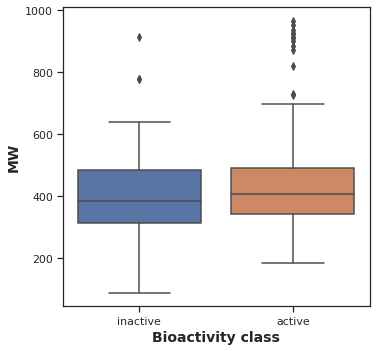

In [52]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'bioactivity_class', y = 'MW', data = df_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('MW', fontsize=14, fontweight='bold')

plt.savefig('plot_MW.pdf')

In [53]:
mannwhitney('MW')

,Descriptor,Statistics,p,alpha,Interpretation
0,MW,331948.5,0.000045,0.05,Different distribution (reject H0)


#### **LogP**

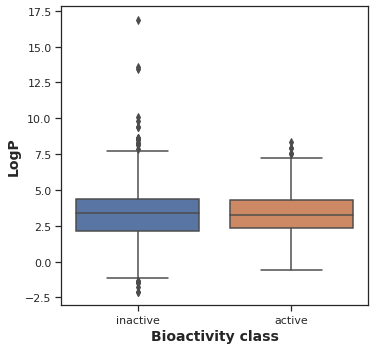

In [54]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'bioactivity_class', y = 'LogP', data = df_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('LogP', fontsize=14, fontweight='bold')

plt.savefig('plot_LogP.pdf')

**Statistical analysis | Mann-Whitney U Test**

In [55]:
mannwhitney('LogP')

,Descriptor,Statistics,p,alpha,Interpretation
0,LogP,374472.5,0.456698,0.05,Same distribution (fail to reject H0)


#### **NumHDonors**

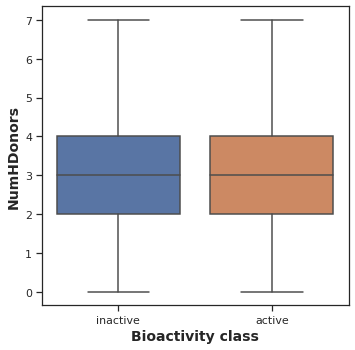

In [56]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'bioactivity_class', y = 'NumHDonors', data = df_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('NumHDonors', fontsize=14, fontweight='bold')

plt.savefig('plot_NumHDonors.pdf')

**Statistical analysis | Mann-Whitney U Test**

In [57]:
mannwhitney('NumHDonors')

,Descriptor,Statistics,p,alpha,Interpretation
0,NumHDonors,358037.5,0.050977,0.05,Same distribution (fail to reject H0)


#### **NumHAcceptors**

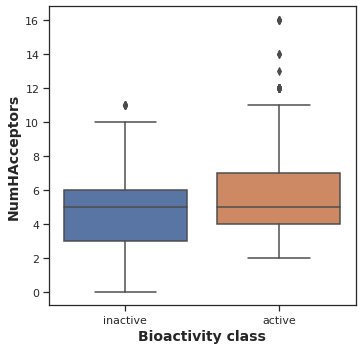

In [58]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'bioactivity_class', y = 'NumHAcceptors', data = df_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('NumHAcceptors', fontsize=14, fontweight='bold')

plt.savefig('plot_NumHAcceptors.pdf')

In [59]:
mannwhitney('NumHAcceptors')

,Descriptor,Statistics,p,alpha,Interpretation
0,NumHAcceptors,292183.5,1.803337e-14,0.05,Different distribution (reject H0)


#### **Interpretation of Statistical Results**

###### **pIC50 values**

Considering pIC50 values, the **actives** and **inactives** displayed ***statistically significant difference***, which is to be expected since threshold values (``IC50 < 1,000 nM = Actives while IC50 > 10,000 nM = Inactives``, corresponding to ``pIC50 > 6 = Actives and pIC50 < 5 = Inactives``) were used to classify actives and inactives.

###### **Lipinski's descriptors**

Of the 4 Lipinski's descriptors, MW and Number of H acceptors exhibited ***statistically significant difference*** between the **actives** and **inactives** while number of H donors and LogP did not exhibit statistically significant difference. It should be noted that the actual difference between actives and inactives for MW and Number of H acceptors was very small, but due to the large sample size even a ***marginal difference*** can produce statistical significance. 